In [ ]:
wimport numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.19.0
Built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(19, 19, 1), learning_rate=0.001):

    model = models.Sequential([
        keras.Input(shape=input_shape),

        #First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        #Flatten + Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),


        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



def plot_training_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend(fontsize=10)


    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend(fontsize=10)


    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names=None):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test, class_names=None):

    y_pred_proba = model.predict(X_test, verbose=0)
    if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()


    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}\n")

    print(classification_report(y_test, y_pred, target_names=class_names))

    plot_confusion_matrix(y_test, y_pred, class_names)

    return y_pred




In [ ]:
from google.colab import drive

#add data to drive and keep in folder and name it data
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# # Load data
# H_train_data  = np.load("drive/MyDrive/data/H_train_data.npy", allow_pickle=True)
# MDD_train_data = np.load("drive/MyDrive/data/MDD_train_data.npy", allow_pickle=True)

# H_test_data   = np.load("drive/MyDrive/data/H_test_data.npy", allow_pickle=True)
# MDD_test_data = np.load("drive/MyDrive/data/MDD_test_data.npy", allow_pickle=True)

# # Create labels
# y_train = np.concatenate([np.zeros(len(H_train_data)), np.ones(len(MDD_train_data))])
# y_test  = np.concatenate([np.zeros(len(H_test_data)),  np.ones(len(MDD_test_data))])

# X_train = np.concatenate([H_train_data, MDD_train_data], axis=0)
# X_test  = np.concatenate([H_test_data, MDD_test_data], axis=0)

# # Split half of test data as validation
# X_train_new, X_val, y_train_new, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# )

# print("X_train:", X_train.shape)
# print("y_train:", y_train.shape)
# print("X_val:", X_val.shape)
# print("y_val:", y_val.shape)
# print("X_train_new:", X_train_new.shape)
# print("y_train_new:", y_train_new.shape)
# print("X_test:", X_test.shape)
# print("y_test:", y_test.shape)


X_train: (21267, 19, 19)
y_train: (21267,)
X_val: (4254, 19, 19)
y_val: (4254,)
X_train_new: (17013, 19, 19)
y_train_new: (17013,)
X_test: (4628, 19, 19)
y_test: (4628,)


In [ ]:
H_train_data  = np.load("drive/MyDrive/new_data/H_train_data.npy", allow_pickle=True)
MDD_train_data = np.load("drive/MyDrive/new_data/MDD_train_data.npy", allow_pickle=True)

H_test_data   = np.load("drive/MyDrive/new_data/H_test_data.npy", allow_pickle=True)
MDD_test_data = np.load("drive/MyDrive/new_data/MDD_test_data.npy", allow_pickle=True)

H_val_data  = np.load("drive/MyDrive/new_data/H_val_data.npy", allow_pickle=True)
MDD_val_data = np.load("drive/MyDrive/new_data/MDD_val_data.npy", allow_pickle=True)

print("H_train_data:", H_train_data.shape)
print("MDD_train_data:", MDD_train_data.shape)
print("H_test_data:", H_test_data.shape)
print("MDD_test_data:", MDD_test_data.shape)
print("H_val_data:", H_val_data.shape)
print("MDD_val_data:", MDD_val_data.shape)

X_train = np.concatenate([H_train_data, MDD_train_data], axis=0)
X_test  = np.concatenate([H_test_data, MDD_test_data], axis=0)
X_val   = np.concatenate([H_val_data, MDD_val_data], axis=0)

y_train = np.concatenate([np.zeros(len(H_train_data)), np.ones(len(MDD_train_data))])
y_test  = np.concatenate([np.zeros(len(H_test_data)),  np.ones(len(MDD_test_data))])
y_val   = np.concatenate([np.zeros(len(H_val_data)), np.ones(len(MDD_val_data))])

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)



H_train_data: (12609, 19, 19)
MDD_train_data: (13798, 19, 19)
H_test_data: (2475, 19, 19)
MDD_test_data: (2102, 19, 19)
H_val_data: (2473, 19, 19)
MDD_val_data: (2420, 19, 19)
X_train: (26407, 19, 19)
y_train: (26407,)
X_val: (4893, 19, 19)
y_val: (4893,)
X_test: (4577, 19, 19)
y_test: (4577,)


X_train_new: (26407, 19, 19, 1)
y_train_new: (26407,)
X_val: (4893, 19, 19, 1)
y_val: (4893,)
X_test: (4577, 19, 19, 1)
y_test: (4577,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 19, 19, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 19, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,993 (1.27 MB)

 Trainable params: 332,673 (1.27 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7225 - loss: 0.5712 - val_accuracy: 0.5806 - val_loss: 0.7522 - learning_rate: 0.0010
Epoch 2/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8051 - loss: 0.4192 - val_accuracy: 0.6307 - val_loss: 0.7244 - learning_rate: 0.0010
Epoch 3/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8279 - loss: 0.3729 - val_accuracy: 0.6274 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 4/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8467 - loss: 0.3408 - val_accuracy: 0.6123 - val_loss: 0.9817 - learning_rate: 0.0010
Epoch 5/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8649 - loss: 0.3057 - val_accuracy: 0.6188 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 6/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8692 - loss: 0.2946 - val_accuracy: 0.6184 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 7/50
816/826 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8817 - loss: 0.2763
E

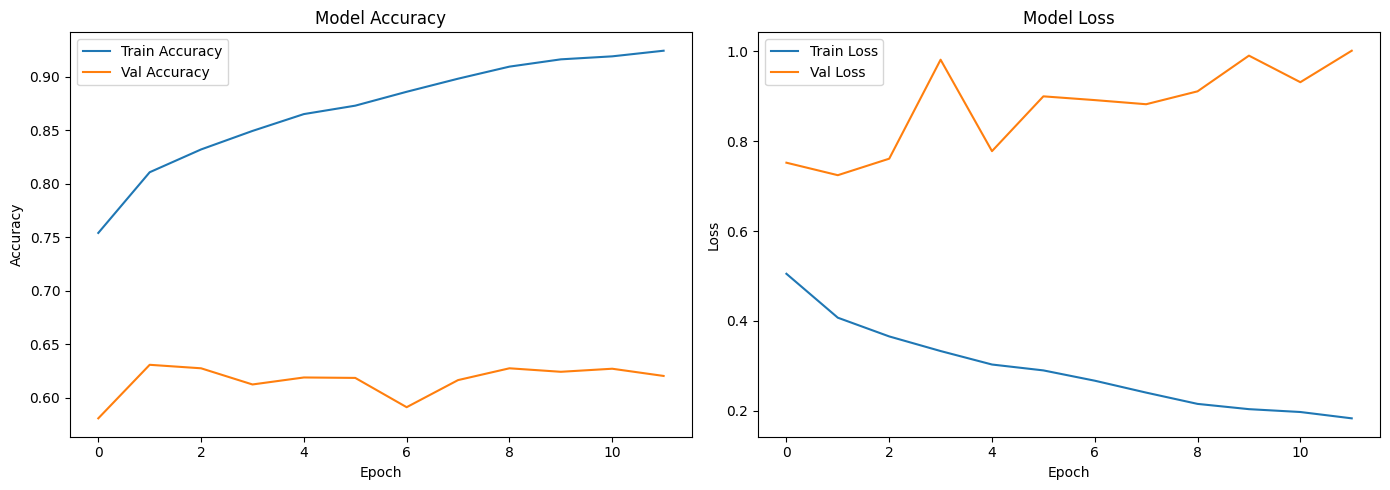

Test Accuracy: 0.5095

              precision    recall  f1-score   support

           H       0.55      0.50      0.52      2475
         MDD       0.47      0.52      0.49      2102

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



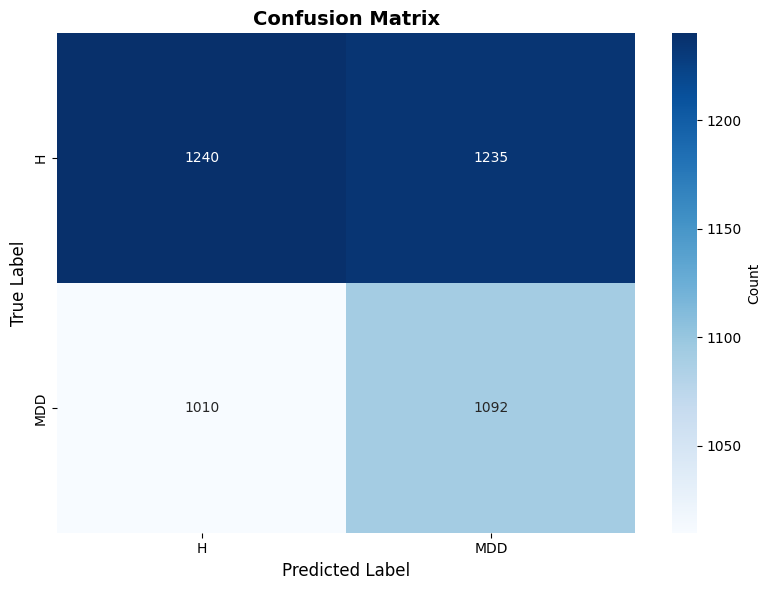

Model saved as: /content/drive/MyDrive/phys188models/granger_cnn_model_20251212_110209.keras


In [ ]:
# Add channel dimension
X_train = X_train[..., np.newaxis].astype(np.float32)
X_val   = X_val[..., np.newaxis].astype(np.float32)
X_test  = X_test[..., np.newaxis].astype(np.float32)  # updated to new test set

print("X_train_new:", X_train.shape)
print("y_train_new:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Create
model = create_cnn_model(learning_rate=0.001)
model.summary()

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
)

# Plot training history
plot_training_history(history)

# Evaluate on the updated test set
class_names = ['H', 'MDD']
y_pred = evaluate_model(model, X_test, y_test, class_names)

# Save model
import os
from datetime import datetime

save_dir = "/content/drive/MyDrive/phys188models"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"{save_dir}/granger_cnn_model_{timestamp}.keras"
model.save(model_path)

print(f"Model saved as: {model_path}")


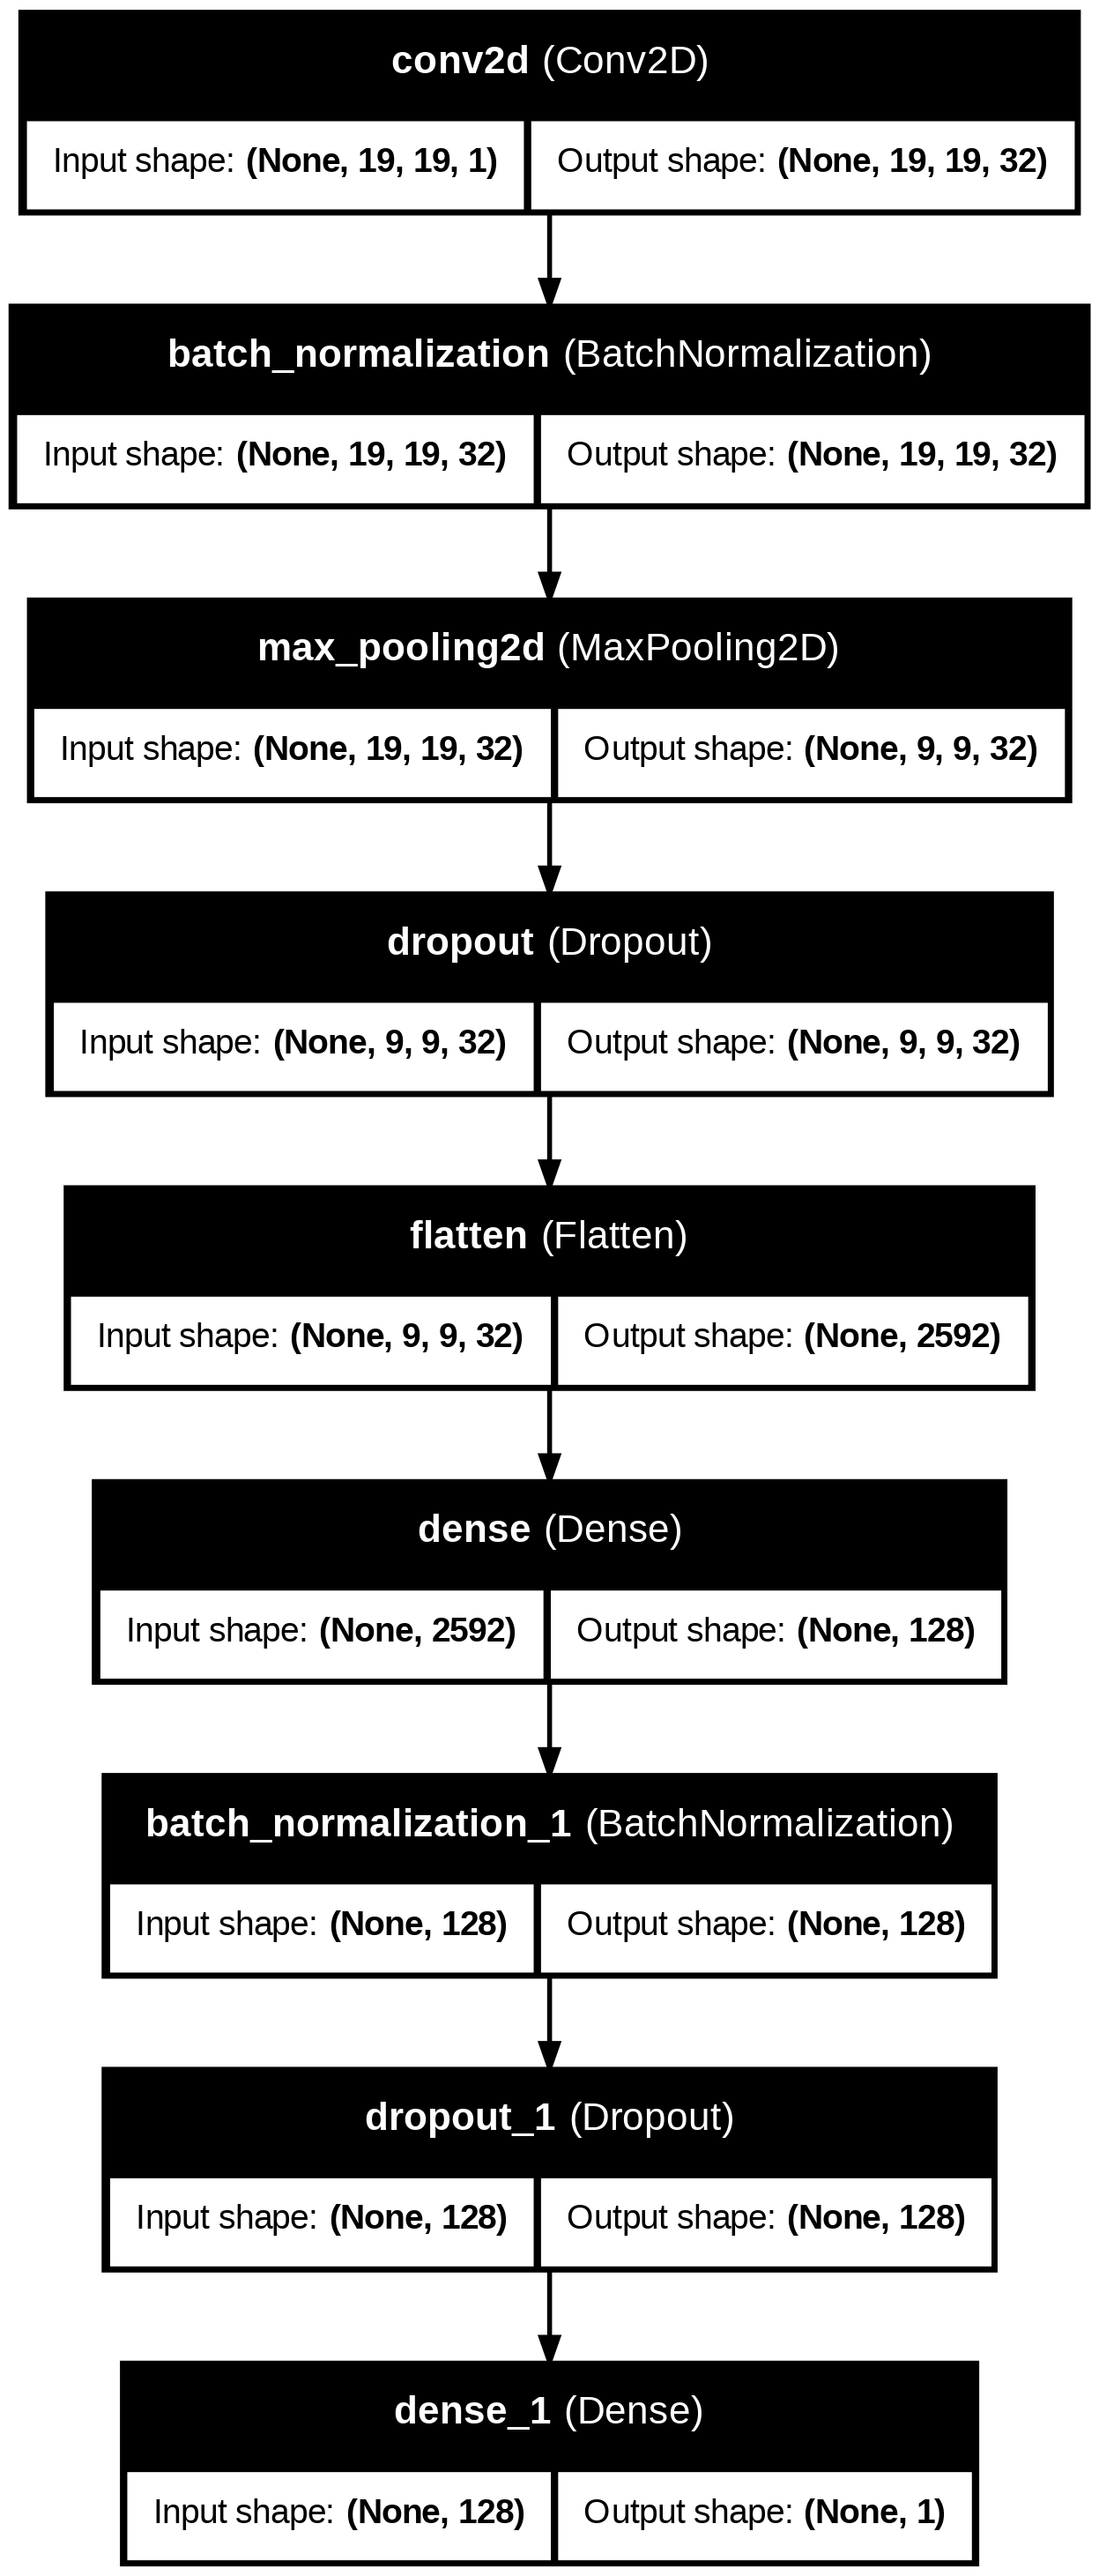

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
pip install -q -U keras-tuner


In [ ]:
import keras_tuner as kt

In [ ]:
def build_cnn_model(hp):
    model = keras.Sequential()

    model.add(keras.Input(shape=(19, 19, 1)))

    num_blocks = hp.Int("num_blocks", 1, 4)

    activation = hp.Choice("activation", ["relu"])

    filters_start = hp.Int("filters_start", 16, 128, step=16)

    for i in range(num_blocks):
        filters = filters_start * (2 ** i)

        model.add(layers.Conv2D(
            filters=filters,
            kernel_size=hp.Choice(f"kernel_size_{i}", [1, 5]),
            activation=activation,
            padding="same"
        ))
        model.add(layers.BatchNormalization())


        if hp.Boolean(f"pool_block_{i}"):
            model.add(layers.MaxPooling2D(pool_size=2))


        model.add(layers.Dropout(
            hp.Float(f"dropout_block_{i}", 0.0, 0.5, step=0.1)
        ))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        hp.Int("dense_units", 64, 512, step=64),
        activation=activation
    ))
    model.add(layers.Dropout(
        hp.Float("dense_dropout", 0.0, 0.5, step=0.1)
    ))

    lr = hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")


    optimizer = keras.optimizers.Adam(lr)


    # Output
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model


In [ ]:
tuner = kt.Hyperband(
    build_cnn_model,
    objective="val_accuracy",
    max_epochs=30,
    factor=3,
    directory="hypertuning_results",
    project_name="granger_cnn_12-12"
)


early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    epochs=50,
    batch_size=32
)


best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.get_best_models(1)[0]

print("Best hyperparameters:")
for hp_name in best_hp.values.keys():
    print(hp_name, ":", best_hp.get(hp_name))


Trial 90 Complete [00h 00m 28s]
val_accuracy: 0.6482730507850647

Best val_accuracy So Far: 0.6723891496658325
Total elapsed time: 00h 43m 04s
Best hyperparameters:
num_blocks : 4
activation : relu
filters_start : 112
kernel_size_0 : 5
pool_block_0 : False
dropout_block_0 : 0.1
dense_units : 512
dense_dropout : 0.0
learning_rate : 0.0002655583594679016
kernel_size_1 : 1
pool_block_1 : True
dropout_block_1 : 0.1
tuner/epochs : 30
tuner/initial_epoch : 10
tuner/bracket : 3
tuner/round : 3
kernel_size_2 : 1
pool_block_2 : False
dropout_block_2 : 0.0
kernel_size_3 : 1
pool_block_3 : False
dropout_block_3 : 0.0
tuner/trial_id : 0049


Epoch 1/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7695 - loss: 0.6143 - val_accuracy: 0.6464 - val_loss: 0.9939
Epoch 2/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8870 - loss: 0.2618 - val_accuracy: 0.6035 - val_loss: 1.3137
Epoch 3/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9301 - loss: 0.1701 - val_accuracy: 0.5759 - val_loss: 1.8531
Epoch 4/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9519 - loss: 0.1252 - val_accuracy: 0.6313 - val_loss: 1.5485
Epoch 5/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9634 - loss: 0.0944 - val_accuracy: 0.6205 - val_loss: 1.7517
Epoch 6/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9730 - loss: 0.0758 - val_accuracy: 0.6141 - val_loss: 2.0112
Epoch 7/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9794 - loss: 0.0619 - val_accuracy: 0.5598 - val_loss: 2.4572
Epoch 8/100
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 

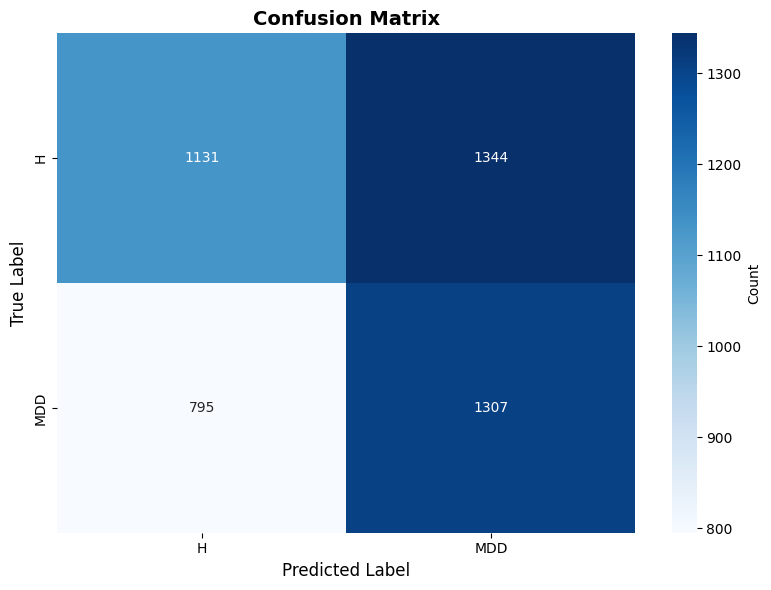

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

early_stop_final = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_final],
    verbose=1
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
path =  f"{save_dir}/granger_cnn_model_{timestamp}.keras"
model.save(path)

evaluate_model(model, X_test, y_test, class_names=['H', 'MDD'])
